<a href="https://colab.research.google.com/github/mmmarcopalma/terrain-tiles/blob/main/Terrain_Tiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Access Terrain Tiles from Amazon Web Server (AWS) and export elevation data to .csv

About Terrain Tiles

https://registry.opendata.aws/terrain-tiles/

https://github.com/tilezen/joerd/tree/master/docs

https://github.com/tilezen/joerd/blob/master/docs/data-sources.md

Explore and Search Tiles

https://eos.com/landviewer/ - change search settings to Terrain Tiles

https://elevation-tiles-prod.s3.amazonaws.com/index.html#4/14.82/-403.59


### Authorize access to gdrive

In [ ]:
# manage authorization token to access gdrive account
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


### Import libraries

In [1]:
# import additional libraries
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.colors as col
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import math
# install and import rasterio
!pip install rasterio
import rasterio as rio
from rasterio.plot import show

     |████████████████████████████████| 19.1MB 1.4MB/s 


### Tile from Lat / Long

In [2]:
# get tile from latitude / longitude
# >>> https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames

latitude = 39.7357
longitude = 21.6638
zoom_level = 11

def deg2tile(lat_deg, lon_deg, zoom):
  lat_rad = math.radians(lat_deg)
  n = 2.0 ** zoom
  xtile = int((lon_deg + 180.0) / 360.0 * n)
  ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
  return (xtile, ytile)

tile_x, tile_y = deg2tile(latitude, longitude, zoom_level)
tile_z = zoom_level

print("Tile X = ", tile_x)
print("Tile Y = ", tile_y)

Tile X =  1147
Tile Y =  777


### Ground Resolution from Lat / Long

In [3]:
ground_resolution = (math.cos(latitude * math.pi/180) * 2 * math.pi * 6378137 ) / (256 * 2**(zoom_level+1))

print("Ground Resolution =", int(ground_resolution), "meters")

Ground Resolution = 29 meters


### Lat / Long from Tile

In [4]:
# get latitude/longitude from tile 
# >>> https://eos.com/landviewer/

def num2deg(xtile, ytile, zoom):
  n = 2.0 ** zoom
  lon_deg = xtile / n * 360.0 - 180.0
  lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
  lat_deg = math.degrees(lat_rad)
  return (lat_deg, lon_deg)

latitude, longitude = num2deg(1147, 777, 11)

print("Latitude =", round(latitude,6), "°N")
print("Longitude =", round(longitude,6), "°E")


Latitude = 39.774769 °N
Longitude = 21.621094 °E


### Send request to AWS via URL

In [5]:
# manage URL for tile request
# >>> https://github.com/tilezen/joerd/blob/master/docs/use-service.md

path = "http://s3.amazonaws.com/elevation-tiles-prod/geotiff/{0}/{1}/{2}.tif".format(tile_z, tile_x, tile_y)
                                                                                     

### Open and visualize dataset

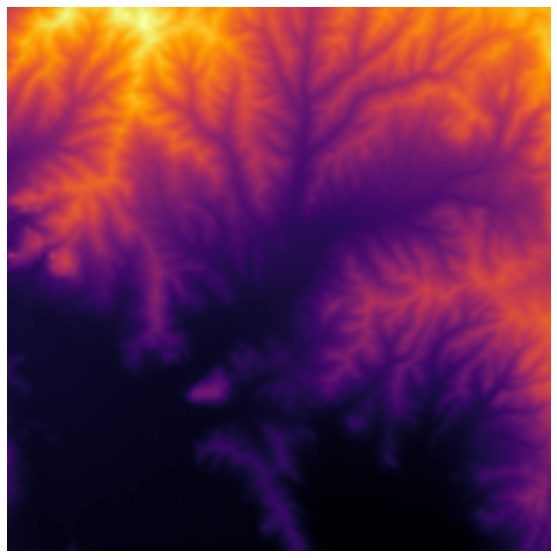

In [6]:
# open image in read mode
dataset = rio.open(path, 'r')

# plot dataset
fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_axis_off()

# colormap options 
# https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
#
# Sequential  _ 'viridis', 'plasma', 'inferno', 'magma', 'cividis' 
#             _ 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 
#               'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu','GnBu', 'PuBu', 'YlGnBu', 
#               'PuBuGn', 'BuGn', 'YlGn'
#             _  'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
#                'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
#                'hot', 'afmhot', 'gist_heat', 'copper'
# Diverging   _ 'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
#               'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic'
# Cyclic      _ 'twilight', 'twilight_shifted', 'hsv'
# Qualitative _ 'Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 
#               'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c'
# Misc        _ 'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
#               'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
#               'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar' 

img = dataset.read(1)
map = 'inferno'
artist = plt.imshow(img, cmap=map)
plt.show(artist)


### Extract Elevation Data

In [ ]:
# interrogate dataset band(s) 
bands = dataset.indexes
print(bands)
print("")

# extract dataset array
elevation_array = dataset.read(1)
print(elevation_array)
print("")
print(elevation_array.shape)
print(elevation_array.size)

(1,)

[[558 561 563 ... 811 810 811]
 [560 563 566 ... 811 811 811]
 [564 567 571 ... 811 811 812]
 ...
 [177 177 177 ... 285 278 271]
 [177 177 177 ... 280 273 265]
 [177 177 177 ... 277 269 261]]

(512, 512)
262144


### Extract Color Data

Info about matplotlib mapper() function

https://stackoverflow.com/questions/28752727/map-values-to-colors-in-matplotlib

In [ ]:
# remap elevation values to colors
e_min = elevation_array.min()
e_max = elevation_array.max()

norm = col.Normalize(vmin=e_min, vmax=e_max, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=map)

# remove alpha channel from array
temp_array = elevation_array
rgba_array = mapper.to_rgba(temp_array)
print("RGBA array _ ", rgba_array.shape)
rgb_array = rgba_array[:,:,:3]
print("RGB  array _ ", rgb_array.shape)
print("")

# remap values to integers 0-255
rgb_array *= 255
print("Remapped floats   _ ", rgb_array[0][0]) 
rgb_array = np.rint(rgb_array).astype(int)
print("Remapped integers _ ", rgb_array[0][0])
print("")

# reshape array for .csv
print("3D array shape _ ", rgb_array.shape)
rgb_array = rgb_array.reshape(512, 512*3)
print("2D array shape _ ", rgb_array.shape)

# rename
color_array = rgb_array

RGBA array _  (512, 512, 4)
RGB  array _  (512, 512, 3)

Remapped floats   _  [194.82255   59.30127   79.406745]
Remapped integers _  [195  59  79]

3D array shape _  (512, 512, 3)
2D array shape _  (512, 1536)


### Save elevation data as .csv

In [ ]:
# define gdrive save directory 
path = "/drive/My Drive/Colab Notebooks/"

# elevation .csv filename
elevation_filename = "TILE_X{0}_Y{1}_Z{2}_ELEVATION.{3}".format(tile_x, tile_y, tile_z, "csv")
color_filename = "TILE_X{0}_Y{1}_Z{2}_COLOR.{3}".format(tile_x, tile_y, tile_z, "csv")
print(elevation_filename)
print(color_filename)

# save .csv at specified gdrive location
np.savetxt(path+elevation_filename , elevation_array, delimiter=";", fmt='%1.0f')
np.savetxt(path+color_filename , color_array, delimiter=";", fmt='%1.0f')

TILE_X1147_Y777_Z11_ELEVATION.csv
TILE_X1147_Y777_Z11_COLOR.csv
